# 16. 다음에 볼 영화 예측하기

**고객이 바로 지금 원하는 것이 무엇인지를 예측하여 추천하는 Session-based Recommendation 개념을 익히고 실제로 모델을 구축해 본다.**

---

## 목차
- Step 1. 데이터의 전처리
- Step 2. 미니 배치의 구성
- Step 3. 모델 구성
- Step 4. 모델 학습
- Step 5. 모델 테스트
- 회고

---

- 라이브러리 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os
from datetime import datetime

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

- 데이터 가져오기

In [2]:
data_path = Path('yoochoose/data/') 
train_path = data_path / 'ratings.dat'

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [4]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 유저 수, 아이템 수 확인
    - 유저 수: 6040
    - 아이템 수: 3706

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### Session Length

- 각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인
- 변수
    - session_length
        - 같은 UserId 를 공유하는 데이터 row 의 개수
        - 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미
    - UserId: 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자

In [6]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
print(f'각 세션 길이의 중앙값: {session_length.median()}')
print(f'각 세션 길이의 평균값: {session_length.mean()}')
print(f'각 세션 길이의 최솟값: {session_length.min()}')
print(f'긱 세션 길이의 최댓값: {session_length.max()}')
print(f'99.9% 세션의 길이: {session_length.quantile(0.999)}')

각 세션 길이의 중앙값: 96.0
각 세션 길이의 평균값: 165.5975165562914
각 세션 길이의 최솟값: 20
긱 세션 길이의 최댓값: 2314
99.9% 세션의 길이: 1343.181000000005


- 세션 길이 기준 하위 99.9%까지의 분포 누적합 시각화

In [8]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

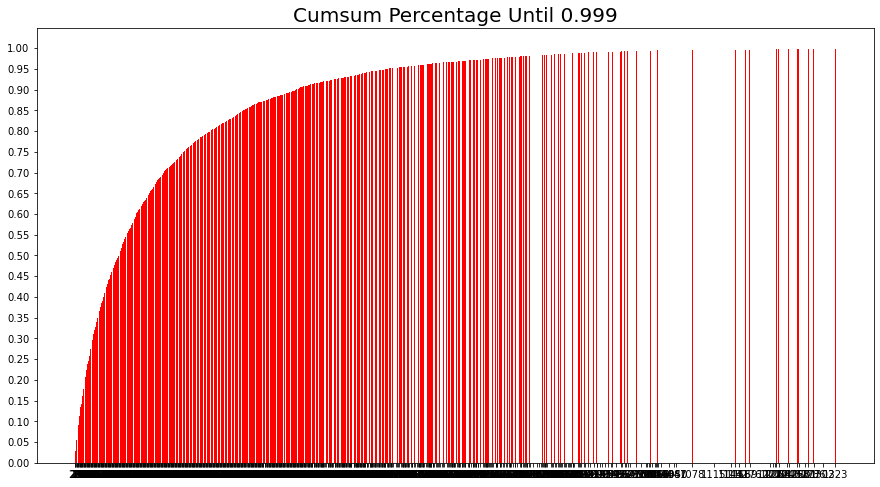

In [9]:
plt.figure(figsize=(15, 8))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Sesstion Time

In [10]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


### Ratings

- 평점 4 이상만 남김

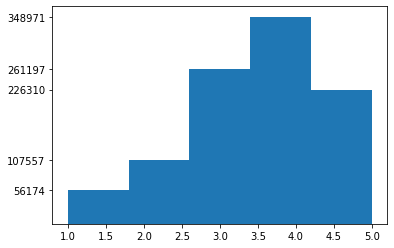

In [12]:
plt.hist(data['Rating'], bins=5)
plt.yticks(data['Rating'].value_counts())
plt.show()

In [13]:
data = data[data['Rating']>=4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  575281 non-null  int32         
 1   ItemId  575281 non-null  int32         
 2   Rating  575281 non-null  int32         
 3   Time    575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 15.4 MB


### Data Cleansing

- 길이가 1인 세션 제거

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=5, least_click=15)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
36,1,1836,5,2001-01-01 07:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 23:39:27
999923,6040,232,5,2001-08-10 23:39:58
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04


### Train / Valid / Test split

In [16]:
data = data.sort_values('Time')
data.head(20)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-26 08:05:32
999873,6040,593,5,2000-04-26 08:05:54
1000153,6040,2384,4,2000-04-26 08:05:54
1000007,6040,1961,4,2000-04-26 08:06:17
1000192,6040,2019,5,2000-04-26 08:06:17
999920,6040,213,5,2000-04-26 08:07:36
999980,6040,3505,4,2000-04-26 08:07:36
999967,6040,3111,5,2000-04-26 08:07:36
999884,6040,912,5,2000-04-26 08:09:51
999888,6040,919,5,2000-04-26 08:09:51


In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [18]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [19]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 558307
	 Sessions: 6031
	 Items: 2562
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-03-05 12:58:17

* valid Set Stats Info
	 Events: 6211
	 Sessions: 365
	 Items: 1808
	 First Time : 2002-03-05 13:38:49
	 Last Time : 2002-09-01 13:20:59

* test Set Stats Info
	 Events: 4729
	 Sessions: 311
	 Items: 1512
	 First Time : 2002-09-02 04:43:16
	 Last Time : 2003-03-01 02:49:50



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Data Pipeline - Session-Parallel Mini-Batch 구현

- SessionDataset

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-26 08:05:32,0
999873,6040,593,5,2000-04-26 08:05:54,1
1000153,6040,2384,4,2000-04-26 08:05:54,2
1000007,6040,1961,4,2000-04-26 08:06:17,3
1000192,6040,2019,5,2000-04-26 08:06:17,4
999920,6040,213,5,2000-04-26 08:07:36,5
999980,6040,3505,4,2000-04-26 08:07:36,6
999967,6040,3111,5,2000-04-26 08:07:36,7
999884,6040,912,5,2000-04-26 08:09:51,8
999888,6040,919,5,2000-04-26 08:09:51,9


In [25]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 558008, 558098, 558307])

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6028, 6029, 6030])

- SessionDataLoader

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-26 08:05:32,0
999873,6040,593,5,2000-04-26 08:05:54,1
1000153,6040,2384,4,2000-04-26 08:05:54,2
1000007,6040,1961,4,2000-04-26 08:06:17,3
1000192,6040,2019,5,2000-04-26 08:06:17,4
999920,6040,213,5,2000-04-26 08:07:36,5
999980,6040,3505,4,2000-04-26 08:07:36,6
999967,6040,3111,5,2000-04-26 08:07:36,7
999884,6040,912,5,2000-04-26 08:09:51,8
999888,6040,919,5,2000-04-26 08:09:51,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  45 116 138]
Label Item Idx are :       [  1  46 117 139]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

- Model Architecture

In [31]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- Hyper-parameter Class

In [32]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

- cf. batch_size 값이 val size 보다 작아야 함!!

In [33]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [34]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(256, 1, 2562)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               392100    
                              (256, 50)]                         
                                                                 
 dropout (Dropout)           (256, 50)                 0         
                                                                 
 dense (Dense)               (256, 2562)               130662    
                                                                 
Total params: 522,762
Trainable params: 522,762
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

- Model Training

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
# 학습 시간이 다소 오래 소요됩니다.
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:03<00:36,  1.84s/it]


	 - Recall@20 epoch 1: 0.050781
	 - MRR@20    epoch 1: 0.008969



Evaluation:   9%|▉         | 2/22 [00:03<00:33,  1.69s/it]


	 - Recall@20 epoch 2: 0.062500
	 - MRR@20    epoch 2: 0.011877



Evaluation:   9%|▉         | 2/22 [00:03<00:34,  1.71s/it]

	 - Recall@20 epoch 3: 0.066406
	 - MRR@20    epoch 3: 0.019220



## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

- Inference

In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [39]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:27,  1.71s/it]

	 - Recall@20: 0.054688
	 - MRR@20: 0.009559



## 하이퍼 파라미터 변경 후 모델 테스트

```python
# GRU4REC Tuning Hyper Parameters
learning_rate_choice = [0.01,0.005,0.001,0.0005,0.0001]
dropout_prob_choice = [0.0,0.1,0.2,0.3,0.4,0.5]  # The dropout rate. Defaults to 0.3.
num_layers_choice = [1,2,3]  # The number of layers in GRU. Defaults to 1.
hidden_size_choice = [128]  # The number of features in the hidden state. Defaults to 128.
embedding_size_choice = [64]  # The embedding size of items. Defaults to 64
loss_type_choice = ['BPR', 'CE']  # Defaults to 'CE'(multi-classification, negative sampling is not needed.)
```

- 개선1
    - lr=0.1
    - drop_rate=0.3
    - batch_size=256

In [41]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.1, epochs=3, k=20)
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:03<00:34,  1.72s/it]


	 - Recall@20 epoch 1: 0.072266
	 - MRR@20    epoch 1: 0.018351



Evaluation:   9%|▉         | 2/22 [00:03<00:36,  1.84s/it]


	 - Recall@20 epoch 2: 0.080078
	 - MRR@20    epoch 2: 0.018983



Evaluation:   9%|▉         | 2/22 [00:03<00:34,  1.74s/it]

	 - Recall@20 epoch 3: 0.078125
	 - MRR@20    epoch 3: 0.019023



In [42]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:27,  1.73s/it]

	 - Recall@20: 0.085938
	 - MRR@20: 0.014516



- 개선2
    - lr=0.1
    - drop_rate=0.3
    - batch_size=128
    - hsz=128

In [43]:
args = Args(tr, val, test, batch_size=128, hsz=128, drop_rate=0.3, lr=0.1, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(128, 1, 2562)]          0         
                                                                 
 GRU (GRU)                   [(128, 128),              1033728   
                              (128, 128)]                        
                                                                 
 dropout_1 (Dropout)         (128, 128)                0         
                                                                 
 dense_1 (Dense)             (128, 2562)               330498    
                                                                 
Total params: 1,364,226
Trainable params: 1,364,226
Non-trainable params: 0
_________________________________________________________________


Evaluation:  44%|████▍     | 20/45 [00:17<00:22,  1.12it/s]


	 - Recall@20 epoch 1: 0.037109
	 - MRR@20    epoch 1: 0.009971



Evaluation:  44%|████▍     | 20/45 [00:17<00:21,  1.17it/s]


	 - Recall@20 epoch 2: 0.047656
	 - MRR@20    epoch 2: 0.011971



Evaluation:  44%|████▍     | 20/45 [00:17<00:21,  1.15it/s]

	 - Recall@20 epoch 3: 0.041797
	 - MRR@20    epoch 3: 0.010948



In [44]:
test_model(model, args, test)

Evaluation:  35%|███▌      | 12/34 [00:11<00:20,  1.08it/s]

	 - Recall@20: 0.040365
	 - MRR@20: 0.007895



---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
SessionId 를 못 만들었다. 채점 끝나고 주말에 다시 시도할 예정이다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- [pathlib](https://docs.python.org/3/library/pathlib.html) 라이브러리
    - os 모듈 vs pathlib 모듈 [[참고]](https://engineer-mole.tistory.com/191)

| **처리내용**                   | **os 및 os.path**    | **pathlib**                             |
| ------------------------------ | -------------------- | --------------------------------------- |
| 현재의 디렉토리를 취득         | os.getcwd()          | Path.cwd()                              |
| 맨 앞의 ~를 홈 디렉토리에 치환 | os.path.expanduser() | Path.expanduser(), Path.home()          |
| 경로의 존재 확인               | os.path.exists()     | Path.exists()                           |
| 디렉토리인가를 판단            | os.path.isdir()      | Path.is_dir()                           |
| 파일인가를 판단                | os.path.isfile()     | Path.is_file()                          |
| 심볼릭 링크인가를 판단         | os.path.islink()     | Path.is_symlink()                       |
| 절대경로인가를 판단            | os.path.isabs()      | PurePath.is_absolute()                  |
| 절대경로로 변환                | os.path.abspath()    | Path.resolve()                          |
| status를 취득                  | os.stat()            | Path.stat(), Path.owner(), Path.group() |
| 경로를 연결                    | os.path.join()       | PurePath.joinpath()                     |
| 파일명을 취득                  | os.path.basename()   | PurePath.name                           |
| 새로운 디렉토리를 취득         | os.path.dirname()    | PurePath.parent                         |
| 확장자를 분할·취득             | os.path.splitext()   | PurePath.

- [GRU(Gated Reccurent Unit)](https://yjjo.tistory.com/18) [[참고1]](https://hyen4110.tistory.com/26) [[참고2]](https://wooono.tistory.com/242) [참고3](https://blog.naver.com/winddori2002/221992543837)
    - GRU 등장
        - LSTM(Long Short Term Memory)
            - RNN 의 치명적 한계점인 Long-term dependency 문제 해결
            - RNN 보다 파라미터 많아짐 => 데이터가 충분하지 않은 경우 오버피팅 발생
            - hidden state, cell state
            - Forget gate, Input gate, Output gate
        - LSTM을 구성하는 Time-Step의 Cell을 조금 더 간소화한 버전
        - ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb6kVlm%2Fbtq4Cs5VOPX%2Fr73EUarFNRgaDGdJ7r1Hvk%2Fimg.png)
    - 데이터 양이 적을 때는, 매개 변수의 양이 적은 GRU가 조금 더 낫고, 데이터 양이 더 많으면 LSTM이 더 낫다고 알려짐
    - GRU는 LSTM과 다르게 Gate가 2개이며, Reset Gate(r)과 Update Gate(z)로 이루어져있다.
        - Reset Gate: short-term dependency
            - 이전 상태를 얼마나 반영/잊어야 하는지 결정
            - 이전 상태 hidden state 와 현재 상태 x 를 받아서 sigmoid 처리
            - GRU의 Hidden State = LSTM의 Cell State + Hidden State
        - Update Gate: long-term dependency
            - 과거(1-z)와 현재(z) 정보(상태)를 각각 얼마만큼의 비율로 반영(유지)할지 결정
            - Update Gate = LSTM의 forget gate + input gate 역할
            - 최종 결과는 다음 상태의 hidden state 로 보내짐
    - Output Gate 없음

| **LSTM**                                            | **GRU**                                                    |
| --------------------------------------------------- | ---------------------------------------------------------- |
| gate 수 3개(forget, input, output)                  | gate 수 2개(reset, update)                                 |
| Control the exposure of memory content (cell state) | Expose the entire cell state to other units in the network |
| Has separate input and forget gates                 | Performs both of these operations together via update gate |
| More parameters                                     | Fewer parameters     

- [GRU4REC](https://arxiv.org/pdf/1511.06939v4.pdf) [[참고1]](https://recbole.io/docs/user_guide/model/sequential/gru4rec.html)
    - ![](https://recbole.io/docs/_images/gru4rec.png)
    - Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표
    - 여러 RNN 계열 모델 중에서 GRU 성능이 가장 좋았음
    - Embedding Layer 사용하지 않았을 때 성능이 더 좋았음 => One-hot Encoding 만 사용
    - Session-Parallel Mini-Batches
        - Session이 끝날 때까지 기다리지 않고 병렬적으로 계산
    - 공식 깃허브: [hidasib/GRU4Rec](https://github.com/hidasib/GRU4Rec)
    - Tuning Hyper Parameters

```python
# GRU4REC Tuning Hyper Parameters
learning_rate_choice = [0.01,0.005,0.001,0.0005,0.0001]
dropout_prob_choice = [0.0,0.1,0.2,0.3,0.4,0.5]  # The dropout rate. Defaults to 0.3.
num_layers_choice = [1,2,3]  # The number of layers in GRU. Defaults to 1.
hidden_size_choice = [128]  # The number of features in the hidden state. Defaults to 128.
embedding_size_choice = [64]  # The embedding size of items. Defaults to 64
loss_type_choice = ['BPR', 'CE']  # Defaults to 'CE'(multi-classification, negative sampling is not needed.)
```

- Evaluation Metrics [[참고1]](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/) [[참고2]](https://danthetech.netlify.app/DataScience/evaluation-metrics-for-recommendation-system)
    - Metrics
        - 특징
            - test set의 전체 데이터를 대상으로 성능을 측정
        - 종류
            - Accracy
                - 정확도
                - 전체 test set에서 긍정과 부정을 포함하여 몇개를 맞았는가
            - Precision
                - 정밀도
                - 모델이 실제로 Positive로 예측한 것 중 실제 Positive인 것의 비율
            - Recall
                - 재현율
                - 실제 True인 것중에 모델이 True라고 예측한 것의 비율
            - F1
                - precision score와 recall score의 조화평균
            - AUC
                - ROC curve 의 면적을 구한 값
                - ROC curve: True positive rate과 1-True negative rate의 비율을 그래프로 그린 것
    - Rank-less Recommendation Metrics
        - 특징
            - 단순히 ‘맞았냐 안맞았냐’를 측정(accuracy)하기보단 ‘맞추되 얼마나 상위에 위치시킬 수 있는가?’가 매우 중요
            - precision, recall은 추천 task에서 precision@k, recall@k라는 변형된 모습으로 사용
            - k개의 추천에 대한 평가지표로서 사용
            - 단점: rank에 따른 상대적인 선호도를 제대로 반영하지 못함
        - 종류
            - Precision@k
                - k개의 추천 중 실제로 사용자가 선호하는 (relevant) 아이템이 얼마나 존재하는지를 측정
                - Precision: 사용자에게 useful한 item을 얼마나 잘 추천해주었는가
            - Recall@k
                - 전체 relevant한 아이템 중 추천된 아이템이 속한 비율 => K 개 추천했을때, 추천되어야했을 relevant item이 몇 개 추천되어져 있느냐
                - Recall: useful stuff에 대한 추천을 최대한 놓치지 않는 것
            - Hit@k: k개의 추천 중에 relevant한 것이 있으면 1 아니면 0
    - Rank-aware Recommendation Metrics
        - 특징
            - Ranked 검색 결과를 평가
            - 추천된 상대적인 위치에 따라서 점수를 차등하여 부여
        - 종류
            - MAP(Mean Average Precision)
                - 전체 사용자에 대해서 평가(=Average precision을 구해서 평균냄)하는 것
                - Average Precision
                    - 한명의 사용자에게 추천한 결과를 평가한 것
                    - precision@k에서 k를 점점 늘려가며 얻게되는 precision score를 평균낸 것
                - Precision은 틀린 예측을 하게 되면 그 값이 떨어지지만, Recall에는 변화가 없다.(분모는 실제로 positive인 개수이므로 변화가 없다)
                - 장점: 여러 가지 relevant한 아이템들을 추천 내에서 상대적인 score로 반영할 수 있다.
                - 단점: 1~5점으로 star를 매기는 rating과 같은 경우에는 적용할 수 없다. => binary rating (1/0)에 최적화
            - MRR(Mean Reciprocal Rank)
                - Reciprocal rank: 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표
                - 정답 아이템이 나온 순번의 역수 값
                - 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것
                - 단점: 추천 상의 몇 개의 relevant아이템이 나오든 첫 번째로 나오는 relevant 아이템만 신경쓴다.
            - nDCG(normalized Discounted Cumulative Gain)
                - CG(Cumulative Gain): relevance score를 더하는 것
                - Discount 개념: relevance score를 등장 위치에 따라 조정하는 것
                - normalize (0~1) 으로 k개의 추천 개수가 커지면 커질수록 점수가 높아지는 단점 해결


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
>|2|RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
>|3|세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

UserId 와 Time 컬럼으로 SessionId 를 만들어서 세션 단위 분석을 진행했다. 모델링하고 학습시켜서 epoch 이 진행될수록 Recall 과 MRR 이 개선되었음을 확인했다. Recall 과 MRR 의 변화를 살펴보았다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
SessionId 를 만들어서 다시 실행해봐야 겠다.